# Tutorial 2.1: One-Body Potential Energy Surface

In this section, we construct, from scratch, a 1-body MB-nrg-style PEF for CH3-NH2.

## 2.1.0 Definitions and Imports

In [94]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
%run Tutorial_2_Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
%run Tutorial_2_Paths.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2.x.y Normal Modes Configuration Generation

Now, we will generate the first batch of configurations for our training set. This batch will come from randomly sampling the vibrational normal modes of methylamine.

First, we need to calculate the vibrational modes of the optimized geometry:

In [63]:
definition_CH3NH2 = read_definition(paths.definitions.systems.CH3NH2)
minimized_structure_CH3NH2, minimized_energy_CH3NH2 = read_system_and_energy(definition_CH3NH2, paths.structures.minimized_CH3NH2)
vibrational_modes_CH3NH2 = read_vibrational_modes(paths.structures.vibrational_modes_CH3NH2)

In [64]:
configuration_generator = NormalModesConfigurationGenerator(
        minimized_structure_CH3NH2,
        vibrational_modes_CH3NH2,
)

configurations_vibrational_modes_CH3NH2 = list(configuration_generator.generate_configurations(num_configs=1000, seed=54321))
write_systems(paths.PIP_CH3NH2.configs.vibrational_modes, configurations_vibrational_modes_CH3NH2)

Will generate configurations over a piecewise temperature distribution.
Temp Distribution: temp (au) = x < 0.05 : 0.0001644078210115607 | x < 0.45 : 0.0008220391050578035 | x < 0.75 : 0.001644078210115607 | x < 0.95 : 0.003288156420231214 | otherwise : 0.008220391050578035 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 1000 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 1000 configs.


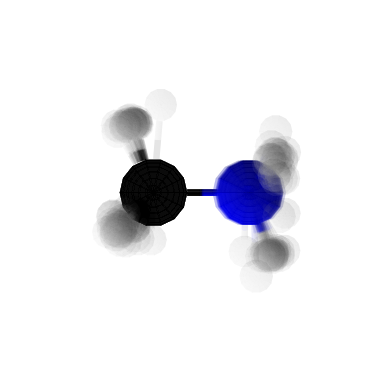

In [65]:
render_overlayed_systems(
    configurations_vibrational_modes_CH3NH2,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.05,
    num_to_show=25
)

Note: the seed here determines which configurations get generated. The same seed will always produce the same configurations. In a later step, we "cheat" and have pre-performed the CCSD(T) calculations for these structures, so please don't change the seed, because then the energies we give you wont match the structures that get generated!

## II.1.? Parallel-Bias Metadynamics Configuration Generation

Let's generate the second set of configurations for our training set, those from metadynamics configurations.

In [66]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        minimized_structure_CH3NH2
)

In [67]:
bond_params

{('A', 'B'): (90, 1.091154370488215),
 ('A', 'C'): (150, 1.4599908872975622),
 ('C', 'D'): (90, 1.0131409832992224)}

In [68]:
angle_params

{('A', 'C', 'D'): (10, 110.03063568497055),
 ('B', 'A', 'C'): (10, 111.09958578700171),
 ('D', 'C', 'D'): (10, 106.47012454924149),
 ('B', 'A', 'B'): (10, 107.7551641938786)}

In [69]:
nonbonded_params

{'A': (0.03, 2.2), 'B': (0.01, 1.2), 'C': (0.03, 2.2), 'D': (0.01, 1.2)}

In [70]:
charges = read_parameters(paths.Vphys.charges)
charges = {symmetry: charges[symmetry]*1/3 for symmetry in charges}

In [71]:
charges

{'A': 0.06570727064098479,
 'B': -0.002438694475163327,
 'C': -0.2174371142753262,
 'D': 0.0795229635299157}

In [72]:
perform_pbmetad_simulation(
        lammps_executable_path,
        [minimized_structure_CH3NH2],
        num_configs=500000,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=paths.PIP_CH3NH2.configs.pbmetad_pool,
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=paths.scratch.pbmetad_CH3NH2,
        restart_path=paths.restart.pbmetad_CH3NH2
)

Preparing PBMetaD Simulation...
Running PBMetaD Simulation...
Converting PBMetaD trajectory to XYZ...


In [73]:
split_pool(
        definition_CH3NH2,
        paths.PIP_CH3NH2.configs.pbmetad_pool,
        pool_size=500000,
        num_configs_to_split=200,
        unsplit_path=paths.PIP_CH3NH2.configs.pbmetad_train_pool,
        split_path=paths.PIP_CH3NH2.configs.pbmetad_test,
        strategy="INTERVAL",
)

In [75]:
pbmetad_configs_CH3NH2 = perform_fps(
        definition_CH3NH2,
        minimized_structure_CH3NH2,
        vibrational_modes_CH3NH2,
        paths.PIP_CH3NH2.configs.pbmetad_train_pool,
        num_pool_configs=500000-200,
        num_phase1_input_configs=100000,
        approx_configs_to_select=1000,
        fps_workdir=paths.scratch.fps_CH3NH2,
        restart_path=paths.restart.fps_CH3NH2,
        num_threads=16
)

Phase1 already complete. Will not rerun.
Phase2 already complete. Will not rerun.
Selected 1561 total configs by FPS.


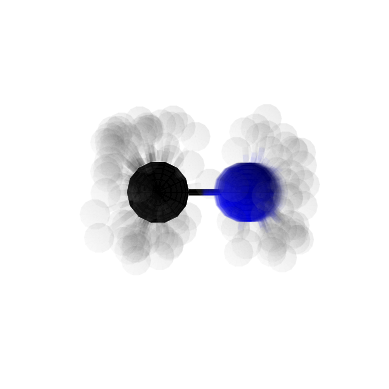

In [76]:
render_overlayed_systems(
    pbmetad_configs_CH3NH2,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.05,
    num_to_show=25
)

In [77]:
write_systems(paths.PIP_CH3NH2.configs.pbmetad_train, pbmetad_configs_CH3NH2)

## II.1.? Energy Calculation

Next, we need to perform the electronic structure calculations with our chosen reference level of theory. We will use CCSD(T). Because this can be quite expensive and this tutorial is menat to be something that can be finished in a few hours, we have precomputed the energies for you. So we will just copy them over:

In [78]:
calculator = Psi4Calculator(
        "MP2",
        "def2-TZVP",
        log_directory=paths.logs,
        scratch_directory=paths.scratch.psi4
)

In [79]:
energies_vibrational_modes_CH3NH2 = calculate_nmer_energies(
        configurations_vibrational_modes_CH3NH2,
        calculator,
        paths.restart.energies_vibrational_mode_configs_CH3NH2,
        num_threads=8,
        mem_mb=8000
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2.configs.vibrational_modes_energies, (configurations_vibrational_modes_CH3NH2, energies_vibrational_modes_CH3NH2))

Running energy calculations |====================================================================================================| - 1000/1000
Completed n-mer energy calculations!


In [80]:
energies_pbmetad_CH3NH2 = calculate_nmer_energies(
        pbmetad_configs_CH3NH2,
        calculator,
        paths.restart.energies_pbmetad_configs_CH3NH2,
        num_threads=8,
        mem_mb=8000
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2.configs.pbmetad_train_energies, (pbmetad_configs_CH3NH2, energies_pbmetad_CH3NH2))

Running energy calculations |====================================================================================================| - 1561/1561
Completed n-mer energy calculations!


In [81]:
energies_1b_vibrational_modes_CH3NH2 = calculate_many_body_energies(
    configurations_vibrational_modes_CH3NH2,
    energies_vibrational_modes_CH3NH2,
    minimized_monomer_energies=[minimized_energy_CH3NH2]
)

energies_1b_pbmetad_CH3NH2 = calculate_many_body_energies(
    pbmetad_configs_CH3NH2,
    energies_pbmetad_CH3NH2,
    minimized_monomer_energies=[minimized_energy_CH3NH2]
)

In [82]:
write_training_set_file(
        paths.PIP_CH3NH2.training_set,
        (
                [*configurations_vibrational_modes_CH3NH2, *pbmetad_configs_CH3NH2],
                [*energies_1b_vibrational_modes_CH3NH2, *energies_1b_pbmetad_CH3NH2],
                [*energies_1b_vibrational_modes_CH3NH2, *energies_1b_pbmetad_CH3NH2],
        )
)

In [83]:
min(energies_1b_vibrational_modes_CH3NH2), max(energies_1b_vibrational_modes_CH3NH2)

(0.19981746999837924, 139.6578174699971)

In [84]:
min(energies_1b_pbmetad_CH3NH2), max(energies_1b_pbmetad_CH3NH2)

(30.318817469997157, 305.8638174699954)

## II.1.? Polynomial Generation

In [85]:
pip_1b_max_order = 3

In [86]:
generate_polynomial(
        definition_CH3NH2,
        max_degree=pip_1b_max_order,
        polynomial_info_path=paths.PIP_CH3NH2.PIP.info,
        polynomial_dir=paths.PIP_CH3NH2.PIP.polynomial,
        filters=[]
)

(A1B3C1D2)
Generating polynomial input file for symmetry (A1B3C1D2) into file Tutorial_2_workdir/PIP_CH3NH2/PIP/info.in.
Successfully generated polynomial input file! 21 total variables.
Generating terms up to degree 3...
Generating polynomial: |====================================================================================================| - 63/63
8 possible degree 1 terms, now filtering them...
There were 8 accepted degree 1 terms.
53 possible degree 2 terms, now filtering them...
There were 53 accepted degree 2 terms.
292 possible degree 3 terms, now filtering them...
There were 292 accepted degree 3 terms.
There were 353 accepted terms over all
Writing Gradients C++: |====================================================================================================| - 21/21
Writing Polynomial C++: |====================================================================================================| - 353/353


## II.1.? Polynomial Parametrization

In [87]:
polarizabilities = read_parameters(paths.Vphys.polarizabilities)
polarizability_factors = read_parameters(paths.Vphys.polarizability_factors)
charges = read_parameters(paths.Vphys.charges)
C6 = read_parameters(paths.Vphys.C6)
d6 = read_parameters(paths.Vphys.d6)

In [88]:
print("polarizabilities:", polarizabilities)
print("polarizability_factors:", polarizability_factors)
print("charges:", charges)
print("C6:", C6)
print("d6:", d6)

polarizabilities: {'A': 1.197286837688588, 'B': 0.3338549392278207, 'C': 0.936690107093768, 'D': 0.35079895087010643, 'E': 1.31, 'F': 0.294}
polarizability_factors: {'A': 1.197286837688588, 'B': 0.3338549392278207, 'C': 0.936690107093768, 'D': 0.35079895087010643, 'E': 1.31, 'F': 0.294}
charges: {'A': 0.19712181192295436, 'B': -0.007316083425489981, 'C': -0.6523113428259786, 'D': 0.2385688905897471}
C6: {('A', 'E'): 213.33108737196045, ('A', 'F'): 101.90479632213754, ('A', 'A'): 287.58772280972653, ('A', 'B'): 100.71518361858206, ('A', 'C'): 245.27149949753883, ('A', 'D'): 101.84278948237693, ('B', 'E'): 81.0911671091582, ('B', 'F'): 37.128317718883046, ('B', 'B'): 36.90402137258849, ('B', 'C'): 89.56084211053388, ('B', 'D'): 37.054828131018624, ('C', 'E'): 196.20342030030648, ('C', 'F'): 90.13727606534552, ('C', 'C'): 217.4097594984364, ('C', 'D'): 89.97192449265054, ('D', 'E'): 80.93270518532552, ('D', 'F'): 37.3074485893026, ('D', 'D'): 37.24888657397313, ('E', 'E'): 237.32122141479

In [89]:
generate_pip_parametizer(
        definition_CH3NH2,
        max_degree=pip_1b_max_order,
        polynomial_info_path=paths.PIP_CH3NH2.PIP.info,
        polynomial_dir=paths.PIP_CH3NH2.PIP.polynomial,
        parametizer_dir=paths.PIP_CH3NH2.PIP.parameterizer,
        workdir=paths.scratch.PIP_CH3NH2,
        symmetry_to_charge=charges,
        symmetry_to_polarizability=polarizabilities,
        symmetry_to_polarizability_factor=polarizability_factors,
        symmetries_to_C6=C6,
        symmetries_to_d6=d6,
        monomer_names=["ch3nh2"],
        is_mbpol=[False]
)

Completed generating config file Tutorial_2_workdir/scratch/PIP_CH3NH2/config.ini.
File Tutorial_2_workdir/scratch/PIP_CH3NH2/config.ini already exists, moving existing Tutorial_2_workdir/scratch/PIP_CH3NH2/config.ini to Tutorial_2_workdir/scratch/PIP_CH3NH2/config.ini.backup-1 to make way for new file.
Executing python generator script
Generating fitcode for molecule with symmetry A1B3C1D2...
Using mbpol for 0 fragments.
0 fragments have lone pairs.
Using exp variables for intramolecular interactions.
Using exp variables for intermolecular interactions.
Using coul variables for lone pair interactions.
353 terms in the polynomial.
Atoms in the molecule: A1 B1 B2 B3 C1 D1 D2.
21 variables in the polynomial.
8 non-linear parameters in the polynomial.
Compiling Parametrizer...
Compiled!


In [33]:
# paths.PIP_CH3NH2.PIP.parametrization.remove()

In [90]:
parametrize_pip(
        definition_CH3NH2,
        parametizer_dir=paths.PIP_CH3NH2.PIP.parameterizer,
        parametrization_dir=paths.PIP_CH3NH2.PIP.parametrization,
        training_set_path=paths.PIP_CH3NH2.training_set,
        workdir=paths.scratch.fitting_CH3NH2,
        monomer_names=["ch3nh2"],
        is_mbpol=[False],
        num_fits_to_run=1,
        num_threads=16,
        DE=10,
        alpha=0.0005
)

Succesfully created fit folder fit1.
fit1 is running.

fit1 is completed.
Best fit is fit fit1.
No previous best fit, so just storing the current best fit.
Best fit found has a weighted RMSD of 0.883031 kcal/mol, a low energy RMSD of 0.281807 kcal/mol, and a maximum error in the low energy training set of 1.58321 kcal/mol


In [31]:
Es = evaluate_pip(
        definition_CH3NH2,
        parametizer_dir=paths.PIP_CH3NH2.PIP.parameterizer,
        parametrization_dir=paths.PIP_CH3NH2.PIP.parametrization,
        training_set_path=paths.PIP_CH3NH2.training_set,
        workdir=paths.scratch.fitting_CH3NH2,
        num_threads=16,
)

## 2.x.y Implementation in MBX

In [113]:
add_PIP_to_MBX(
        paths.MBX,
        definition_CH3NH2,
        ["ch3nh2"],
        paths.PIP_CH3NH2.PIP.parameterizer,
        paths.PIP_CH3NH2.PIP.parametrization,
        max_degree=pip_1b_max_order,
        workdir=paths.scratch.fitting_CH3NH2,
)

Getting polynomial fitted parameters...
Getting energy calls...
***WARNING*** Seems like there is already a mbnrg_1b_A1B3C1D2_deg3_ch3nh2_v1.h file included in SECTION INCLUDE1B. Won't replace anything.
***WARNING*** Seems like there is already a n-mer ch3nh2 defined in SECTION 1B_NO_GRADIENT. Won't replace anything.
***WARNING*** Seems like there is already a n-mer ch3nh2 defined in SECTION 1B_GRADIENT. Won't replace anything.
***WARNING*** Seems like there is already a n-mer ch3nh2 defined in SECTION CONSTRUCTOR. Won't replace anything.


In [114]:
compile_mbx(
        paths.MBX,
        configure_arguments=[
                "CXX=icpc",
                "CC=icc"
        ],
        configure=True,
        clean=False,
        num_threads=4
)

Configuring...
libtoolize: putting auxiliary files in AC_CONFIG_AUX_DIR, `build-aux'.
libtoolize: copying file `build-aux/ltmain.sh'
libtoolize: putting macros in AC_CONFIG_MACRO_DIR, `m4'.
libtoolize: copying file `m4/libtool.m4'
libtoolize: copying file `m4/ltoptions.m4'
libtoolize: copying file `m4/ltsugar.m4'
libtoolize: copying file `m4/ltversion.m4'
libtoolize: copying file `m4/lt~obsolete.m4'
checking for gcc... icc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether icc accepts -g... yes
checking for icc option to accept ISO C89... none needed
checking for ar... ar
checking the archiver (ar) interface... ar
checking build system type... x86_64-unknown-linux-gnu
checking host system type... x86_64-unknown-linux-gnu
checking how to pr